# Crop boundary boxes from data/train from each image for training

In [1]:
!pip install kornia

In [1]:
import os
import glob 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import cv2

In [2]:
MAIN_DIR = "/scratch/st-li1210-1/pearl/karyotype-detector/"
datasets_path = os.path.join(MAIN_DIR,'data')
yolov5_path= os.path.expanduser(MAIN_DIR+'models/yolov5')

In [3]:
# data dir to store cropped bbox chromosomes 
cropped_box_path = os.path.join(MAIN_DIR, 'data', 'cropped_v2')

if os.path.exists(cropped_box_path):
    shutil.rmtree(cropped_box_path)
    
os.makedirs(cropped_box_path)

In [6]:
# set path for 'normal chromosome' training folder from yolov5 training
dataset_yolov5 = os.path.join(datasets_path, 'norm')

In [7]:
from tqdm import tqdm
from PIL import Image, ImageDraw

iou_threshold = 0.1
overlap_count_threshold = 1
dir_list = ['train', 'test', 'val']


def compute_iou(box1, box2):
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    return inter_area / union_area


def filter_boxes_by_overlap(img_path, boxes, iou_threshold=0.1, max_iou_threshold= 0.15, overlap_count_threshold=3):
    keep_boxes = []

    for i, box_a in enumerate(boxes):
        count = 0
        for j, box_b in enumerate(boxes):
            if i == j:
                continue
            iou = compute_iou(box_a[1:], box_b[1:])  # exclude class_id
            # if 0.1 < iou < max_iou_threshold:
            #     show_image(img_path, box_a, box_b)
            if iou >= max_iou_threshold:
                count = overlap_count_threshold
            elif iou >= iou_threshold:
                count += 1
        if count < overlap_count_threshold:
            keep_boxes.append(box_a)
    return keep_boxes


def crop_and_save(image_path, annotations, output_dir, image_base_name):
    """Crop and save bounding boxes from image based on YOLO annotations"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    height, width = img.shape[:2]

    for i, ann in enumerate(annotations):
        
        if len(ann) != 5:
            continue
        class_id, x_c, y_c, w, h = ann
        x_c, y_c, w, h = x_c * width, y_c * height, w * width, h * height

        x_min = int(max(0, x_c - w / 2))
        y_min = int(max(0, y_c - h / 2))
        x_max = int(min(width, x_c + w / 2))
        y_max = int(min(height, y_c + h / 2))

        cropped = img[y_min:y_max, x_min:x_max]
        if cropped.size == 0:
            continue

        out_filename = f"{image_base_name}_class{int(class_id)}_{i}.jpg"
        out_path = os.path.join(output_dir, out_filename)
        cv2.imwrite(out_path, cropped)

for name in dir_list: 
    src_images_path = os.path.join(dataset_yolov5, 'images', name)
    src_labels_path = os.path.join(dataset_yolov5, 'labels', name) 
    dest_images_path = os.path.join(cropped_box_path, name)
    print(dest_images_path)

    if os.path.exists(dest_images_path):
        shutil.rmtree(dest_images_path)
    os.makedirs(dest_images_path)

    txt_files = glob.glob(os.path.join(src_labels_path, "*.txt"))

    for txt_path in tqdm(txt_files):
        base_name = os.path.splitext(os.path.basename(txt_path))[0]
        img_path = os.path.join(src_images_path, base_name + '.jpg')
        
        if not os.path.exists(img_path):
            print(f"Image not found for {base_name}, skipping...")
            continue

        # Parse annotations
        with open(txt_path, 'r') as f:
            annotations = [list(map(float, line.strip().split())) for line in f if line.strip()]


        # Filter out overlapping boxes
        filtered_annotations = filter_boxes_by_overlap(
            img_path, annotations, iou_threshold=iou_threshold, overlap_count_threshold=overlap_count_threshold
        )

        # Crop and save
        crop_and_save(img_path, filtered_annotations, dest_images_path, base_name)


/scratch/st-li1210-1/pearl/karyotype-detector/data/cropped_v2/train


100%|██████████| 3502/3502 [38:10<00:00,  1.53it/s]  


/scratch/st-li1210-1/pearl/karyotype-detector/data/cropped_v2/test


100%|██████████| 438/438 [03:57<00:00,  1.85it/s]


/scratch/st-li1210-1/pearl/karyotype-detector/data/cropped_v2/val


100%|██████████| 438/438 [03:48<00:00,  1.91it/s]


In [8]:
dir_list = ['train', 'test', 'val']

for dir_type in dir_list:
    dir_path = os.path.join(cropped_box_path, dir_type)
    !find "{dir_path}" -type f | wc -l

62007
7961
7573


/scratch/st-li1210-1/pearl/karyotype-detector/data/cropped_v2/train
1052071_class19_5.jpg:


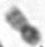

1051091_class19_14.jpg:


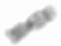

1080062_class19_12.jpg:


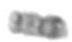

1071491_class14_14.jpg:


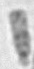

1060571_class9_8.jpg:


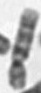

1055651_class7_9.jpg:


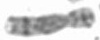

1101473_class13_6.jpg:


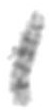

1058181_class13_4.jpg:


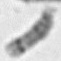

1100213_class1_1.jpg:


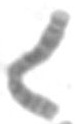

1051902_class18_15.jpg:


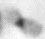

In [10]:
import random
from PIL import Image

def show_random_images(dir_path, num_images=10):
    # List all files in the directory
    all_files = os.listdir(dir_path)

    image_extensions = {'.jpg'}
    image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in image_extensions]

    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    for file_name in selected_files:
        img_path = os.path.join(dir_path, file_name)
        img = Image.open(img_path)
        print(f"{file_name}:")
        img.show()


name = 'train'
directory_path = os.path.join(cropped_box_path, name)
print(directory_path)
show_random_images(directory_path, num_images=10)

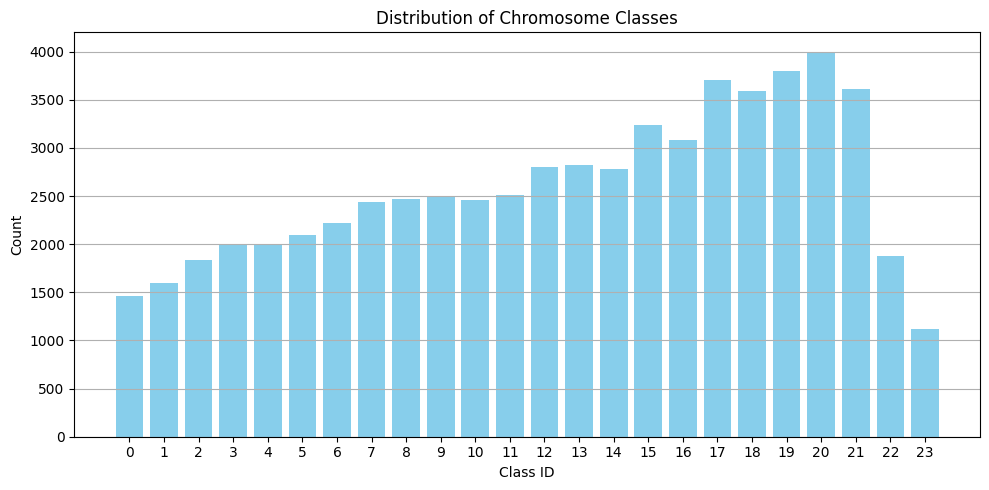

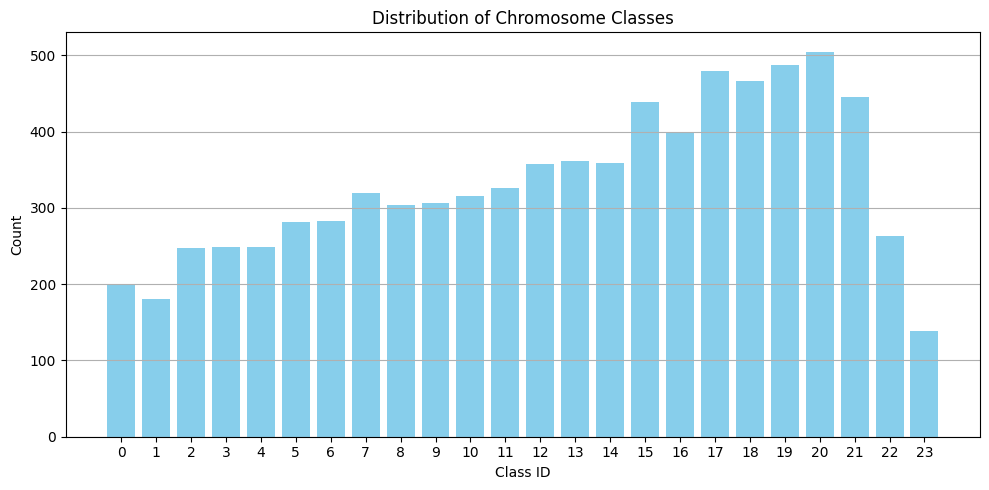

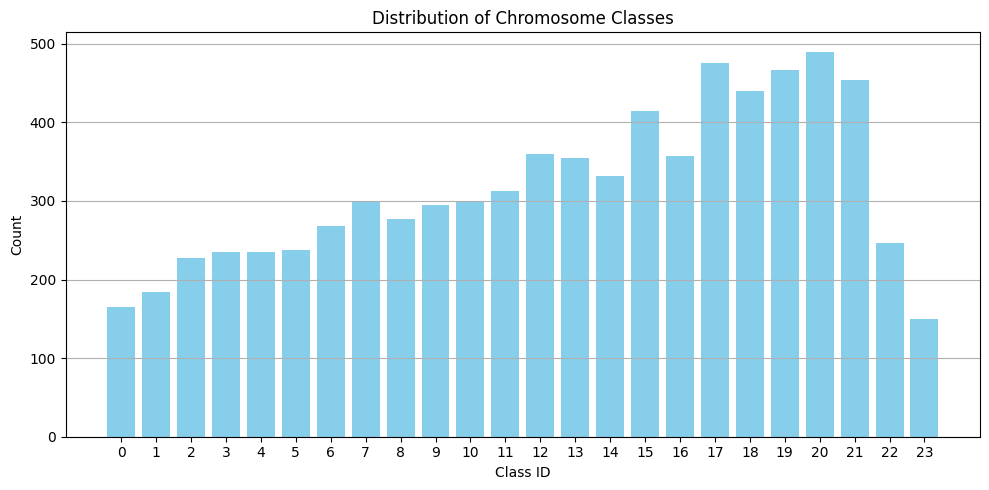

    train  test  val  train_ratio  val_ratio  test_ratio
0    1466   200  165     0.023642   0.021788    0.025122
1    1602   180  184     0.025836   0.024297    0.022610
2    1831   248  227     0.029529   0.029975    0.031152
3    1998   249  235     0.032222   0.031031    0.031277
4    1989   249  235     0.032077   0.031031    0.031277
5    2093   282  237     0.033754   0.031295    0.035423
6    2220   283  268     0.035802   0.035389    0.035548
7    2434   319  300     0.039254   0.039614    0.040070
8    2473   304  277     0.039883   0.036577    0.038186
9    2492   306  295     0.040189   0.038954    0.038437
10   2462   315  299     0.039705   0.039482    0.039568
11   2510   326  312     0.040479   0.041199    0.040950
12   2804   357  360     0.045221   0.047537    0.044844
13   2821   362  354     0.045495   0.046745    0.045472
14   2777   359  332     0.044785   0.043840    0.045095
15   3235   439  414     0.052172   0.054668    0.055144
16   3083   399  357     0.0497

In [11]:
import collections
import re
import pandas as pd

def plot_class_distribution(image_dir):
    # Regex to extract class id from filenames like "1053901_class9_12.jpg"
    class_pattern = re.compile(r'class(\d+)')

    class_counts = collections.Counter()

    for filename in os.listdir(image_dir):
        match = class_pattern.search(filename)
        if match:
            class_id = int(match.group(1))
            class_counts[class_id] += 1

    # Sort by class ID
    sorted_counts = dict(sorted(class_counts.items()))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    plt.title('Distribution of Chromosome Classes')
    plt.xticks(list(sorted_counts.keys()))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    return sorted_counts

# Example usage
counts = {}

for dir_type in dir_list:
    image_directory = os.path.join(cropped_box_path, dir_type)
    counts[dir_type] = plot_class_distribution(image_directory)

df = pd.DataFrame(counts).fillna(0).astype(int)
df['train_ratio'] = df['train'] / df['train'].sum()
df['val_ratio'] = df['val'] / df['val'].sum()
df['test_ratio'] = df['test'] / df['test'].sum()

print(df)

In [12]:
import pandas as pd

def get_image_size(image_directory):
    image_sizes = {}
    for image in tqdm(os.listdir(image_directory)):
        img_path = os.path.join(image_directory, image)
        with Image.open(img_path) as img:
            width, height = img.size
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        image_sizes[file_name] = (width, height)
    return image_sizes


def plot_image_size(image_sizes):
    df_sizes = pd.DataFrame.from_dict(image_sizes, orient='index', columns=['width', 'height'])
    df_sizes.index.name = 'filename'
    df_sizes.reset_index(inplace=True)
    df_sizes['aspect_ratio'] = df_sizes['width'] / df_sizes['height']
    
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8,6))
    plt.scatter(df_sizes['width'], df_sizes['height'], alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Width vs Height')
    plt.grid(True)
    plt.show()
    
    df_sizes['aspect_ratio'].hist(bins=30)
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.title('Distribution of Image Aspect Ratios')
    plt.grid(True)
    plt.show()

100%|██████████| 62007/62007 [43:05<00:00, 23.98it/s]  


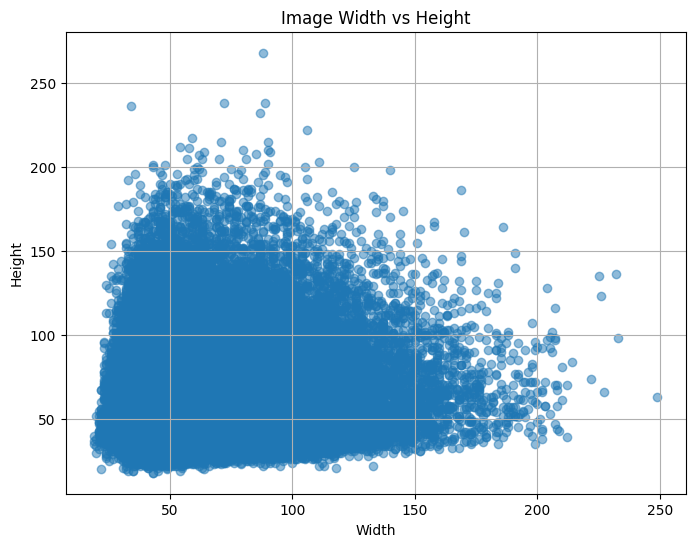

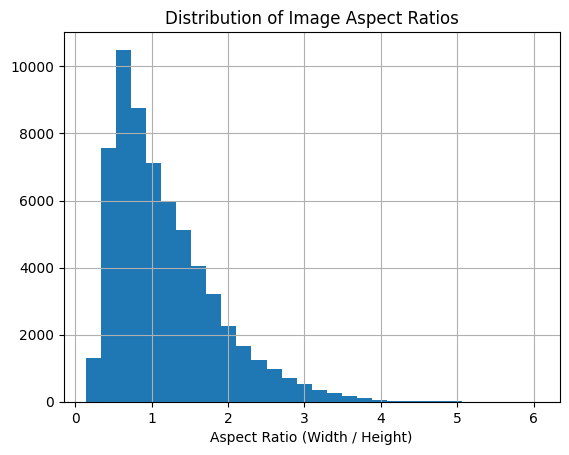

100%|██████████| 7961/7961 [05:27<00:00, 24.34it/s]


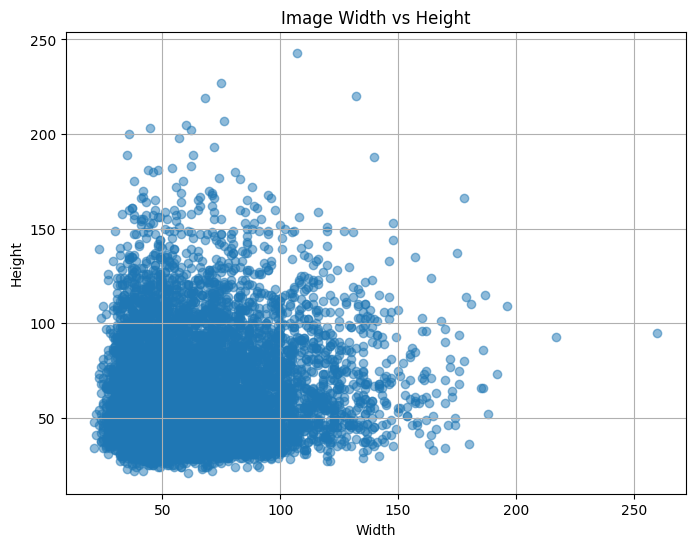

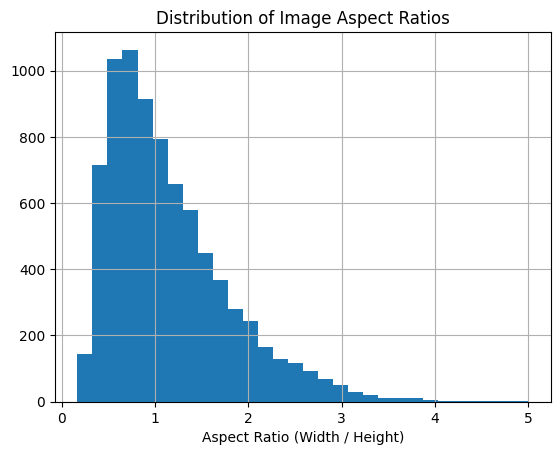

100%|██████████| 7573/7573 [05:02<00:00, 25.04it/s]


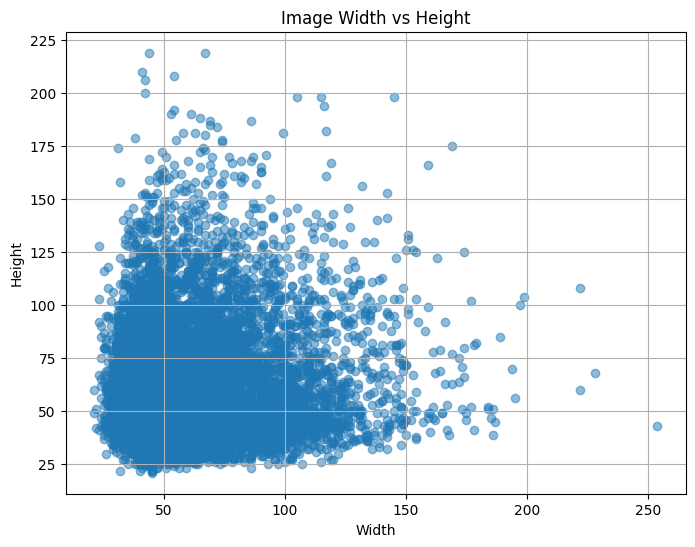

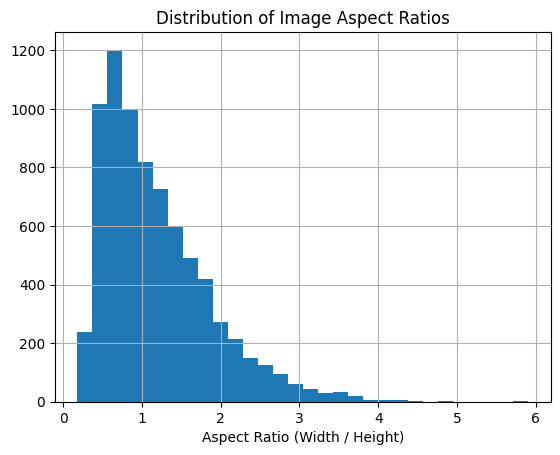

In [13]:
for dir_type in dir_list:
    dir_path = os.path.join(cropped_box_path, dir_type)
    sizes = get_image_size(dir_path)
    plot_image_size(sizes)

In [15]:
recon_dir = os.path.join(cropped_box_path, 'train')
paths = glob.glob(f"{recon_dir}/*.jpg")

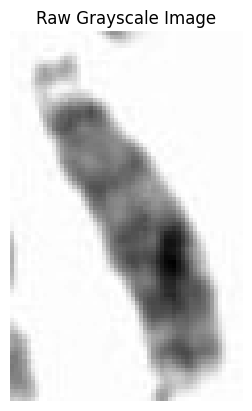

In [19]:
img = cv2.imread(paths[1], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Raw Grayscale Image")
plt.axis('off')
plt.show()

In [20]:
for dir_type in dir_list:
    dir_path = os.path.join(cropped_box_path, dir_type)
    !find "{dir_path}" -type f | wc -l

62007
7961
7573


In [5]:
os.chdir("/scratch/st-li1210-1/pearl/karyotype-detector/models/CVAE/")
!/arc/project/st-li1210-1/pearl/miniconda3/envs/yolov5/bin/python /scratch/st-li1210-1/pearl/karyotype-detector/models/CVAE/main.py \
  --epochs 1 \
  --yaml /scratch/st-li1210-1/pearl/karyotype-detector/models/CVAE/data_filt.yaml \
  --imgsize 64 \
  --exptype train 

/arc/project/st-li1210-1/pearl/miniconda3/envs/yolov5/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Making directory outputs/train/exp108...
Epoch: 1/1 | Beta: 0.1000 | Gamma: 1.0000 | Alpha: 0.1000
Epoch 1/1 [Train]:   0%|                               | 0/1938 [00:00<?, ?it/s]y_map shape: torch.Size([32, 24, 64, 64]), x shape: torch.Size([32, 1, 64, 64])
x_cond shape: torch.Size([32, 25, 64, 64])
Grad Norm: 0.1477
Epoch 1 Batch 0 - Loss: 0.7324, BCE: 0.6616, gamma:1.0, KLD: 0.0161, beta:0.1, SSIM: 0.6915, alpha:0.1, LR: 0.001000
Epoch 1/1 [Train]:   0%|                       | 1/1938 [00:00<30:13,  1.07it/s]y_map shape: torch.Size([32, 24, 64, 64]), x shape: torch.Size([32, 1, 64, 64])
x_cond shape: torch.Size([32, 25, 64, 64])
Grad Norm: 0.4405
Epoch 1 Batch 1 - Loss: 0.7602, B